# import

In [1]:
%autosave 300
import os
import pprint
import tempfile
import tensorflow as tf
from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

Autosaving every 300 seconds


# read data

In this example, we're going to focus on the ratings data. Other tutorials explore how to use the movie information data as well to improve the model quality.

In [58]:
# tfds.list_builders()


The dataset

The Movielens dataset is a classic dataset from the [GroupLens](https://grouplens.org/datasets/movielens/) research group at the University of Minnesota. It contains a set of ratings given to movies by a set of users, and is a workhorse of recommender system research.

The data can be treated in two ways:

1. It can be interpreted as expressesing which movies the users watched (and rated), and which they did not. This is a form of implicit feedback, where users' watches tell us which things they prefer to see and which they'd rather not see.
2. It can also be seen as expressesing how much the users liked the movies they did watch. This is a form of explicit feedback: given that a user watched a movie, we can tell roughly how much they liked by looking at the rating they have given.

In [4]:
movies = tfds.load("movielens/100k-movies",data_dir= '/data/jyu29/data/recommendation_data/tf_dataset', split="train")

ratings = tfds.load("movielens/100k-ratings",data_dir= '/data/jyu29/data/recommendation_data/tf_dataset', split="train")


In [2]:
# for x in movies.take(1).as_numpy_iterator():pprint.pprint(x)

In [3]:
# for x in ratings.take(2).as_numpy_iterator():pprint.pprint(x)

In [6]:
tfds.as_dataframe(ratings.take(2)).T

,0,1
bucketized_user_age,45.0,25.0
movie_genres,[7],"[4, 14]"
movie_id,b'357',b'709'
movie_title,"b""One Flew Over the Cuckoo's Nest (1975)""",b'Strictly Ballroom (1992)'
raw_user_age,46.0,32.0
timestamp,879024327,875654590
user_gender,True,True
user_id,b'138',b'92'
user_occupation_label,4,5
user_occupation_text,b'doctor',b'entertainment'


In [7]:
tfds.as_dataframe(movies.take(2))

,movie_genres,movie_id,movie_title
0,[4],b'1681',b'You So Crazy (1994)'
1,[4 7],b'1457',b'Love Is All There Is (1996)'


## data processing

We keep only the user_id, and movie_title fields in the dataset.

In [8]:
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
})
movies = movies.map(lambda x: x["movie_title"])

To fit and evaluate the model, we need to split it into a training and evaluation set. In an industrial recommender system, this would most likely be done by time: the data up to time  𝑇  would be used to predict interactions after  𝑇 .

In this simple example, however, let's use a random split, putting 80% of the ratings in the train set, and 20% in the test set.

In [10]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

Let's also figure out unique user ids and movie titles present in the data. 

This is important because we need to be able to map the raw values of our categorical features to embedding vectors in our models. To do that, we need a vocabulary that maps a raw feature value to an integer in a contiguous range: this allows us to look up the corresponding embeddings in our embedding tables.

In [12]:
# Displaying the corresponding data according to the embedded tables.
movie_titles = movies.batch(1_000)
user_ids = ratings.batch(1_000_000).map(lambda x: x["user_id"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

unique_movie_titles[:10]

array([b"'Til There Was You (1997)", b'1-900 (1994)',
       b'101 Dalmatians (1996)', b'12 Angry Men (1957)', b'187 (1997)',
       b'2 Days in the Valley (1996)',
       b'20,000 Leagues Under the Sea (1954)',
       b'2001: A Space Odyssey (1968)',
       b'3 Ninjas: High Noon At Mega Mountain (1998)',
       b'39 Steps, The (1935)'], dtype=object)

## sequential data

In [59]:
!wget -nc https://raw.githubusercontent.com/tensorflow/examples/master/lite/examples/recommendation/ml/data/example_generation_movielens.py


wget: /data/guandata/anaconda/lib/libuuid.so.1: no version information available (required by wget)
--2022-02-21 14:26:41--  https://raw.githubusercontent.com/tensorflow/examples/master/lite/examples/recommendation/ml/data/example_generation_movielens.py
正在解析主机 proxy-internet-aws-china-production.subsidia.org (proxy-internet-aws-china-production.subsidia.org)... 10.50.130.241, 10.50.130.117
正在连接 proxy-internet-aws-china-production.subsidia.org (proxy-internet-aws-china-production.subsidia.org)|10.50.130.241|:3128... 已连接。
已发出 Proxy 请求，正在等待回应... 200 OK
长度：18040 (18K) [text/plain]
正在保存至: “example_generation_movielens.py”

100%[======================================>] 18,040      --.-K/s 用时 0.007s    

2022-02-21 14:26:42 (2.47 MB/s) - 已保存 “example_generation_movielens.py” [18040/18040])



In [60]:
!python -m example_generation_movielens  --data_dir=/data/jyu29/data/recommendation_data/tf_dataset  --output_dir=/data/jyu29/data/recommendation_data/tf_dataset --min_timeline_length=3  --max_context_length=10  --max_context_movie_genre_length=10  --min_rating=2  --train_data_fraction=0.9  --build_vocabs=False


2022-02-21 14:27:41.227468: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/data/guandata/anaconda/lib/
2022-02-21 14:27:41.227506: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-21 14:27:41.227527: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ppfgn1ana02): /proc/driver/nvidia/version does not exist
I0221 14:27:41.227639 139690314635072 example_generation_movielens.py:460] Downloading and extracting data.
5931008/5917549 [==============================] - 243s 41us/step
I0221 14:31:45.969362 139690314635072 example_generation_movielens.py:406] Reading data to dataframes.
/home/admin/wallixadm/recommendation/example_generation_movielens.py:132: ParserWarning: Falling back to the 'python' engine bec

In [68]:
train_filename = "/data/jyu29/data/recommendation_data/tf_dataset/train_movielens_1m.tfrecord"
train = tf.data.TFRecordDataset(train_filename)


In [69]:
test_filename = "/data/jyu29/data/recommendation_data/tf_dataset/test_movielens_1m.tfrecord"
test = tf.data.TFRecordDataset(test_filename)

In [70]:
feature_description = {
    'context_movie_id': tf.io.FixedLenFeature([10], tf.int64, default_value=np.repeat(0, 10)),
    'context_movie_rating': tf.io.FixedLenFeature([10], tf.float32, default_value=np.repeat(0, 10)),
    'context_movie_year': tf.io.FixedLenFeature([10], tf.int64, default_value=np.repeat(1980, 10)),
    'context_movie_genre': tf.io.FixedLenFeature([10], tf.string, default_value=np.repeat("Drama", 10)),
    'label_movie_id': tf.io.FixedLenFeature([1], tf.int64, default_value=0),
}

In [71]:
def _parse_function(example_proto):
    return tf.io.parse_single_example(example_proto, feature_description)

train_ds = train.map(_parse_function).map(lambda x: {
    "context_movie_id": tf.strings.as_string(x["context_movie_id"]),
    "label_movie_id": tf.strings.as_string(x["label_movie_id"])
})

test_ds = test.map(_parse_function).map(lambda x: {
    "context_movie_id": tf.strings.as_string(x["context_movie_id"]),
    "label_movie_id": tf.strings.as_string(x["label_movie_id"])
})

for x in train_ds.take(1).as_numpy_iterator():
    pprint.pprint(x)

{'context_movie_id': array([b'3512', b'2961', b'2763', b'2337', b'2987', b'3793', b'1200',
       b'1260', b'2391', b'16'], dtype=object),
 'label_movie_id': array([b'1274'], dtype=object)}


In [72]:
tfds.as_dataframe(train_ds.take(1))

,context_movie_id,label_movie_id
0,[b'3512' b'2961' b'2763' b'2337' b'2987' b'3793' b'1200' b'1260' b'2391' b'16'],[b'1274']


In [73]:
movies = tfds.load("movielens/1m-movies", data_dir= '/data/jyu29/data/recommendation_data/tf_dataset',split='train')
movies = movies.map(lambda x: x["movie_id"])
movie_ids = movies.batch(1_000)
unique_movie_ids = np.unique(np.concatenate(list(movie_ids)))


Dataset movielens downloaded and prepared to /data/jyu29/data/recommendation_data/tf_dataset/movielens/1m-movies/0.1.0. Subsequent calls will reuse this data.


In [77]:
tfds.as_dataframe(movies.take(1))

,
0,b'1729'


# Two towers model

Choosing the architecture of our model is a key part of modelling.

Because we are building a two-tower retrieval model, we can build each tower separately and then combine them in the final model.

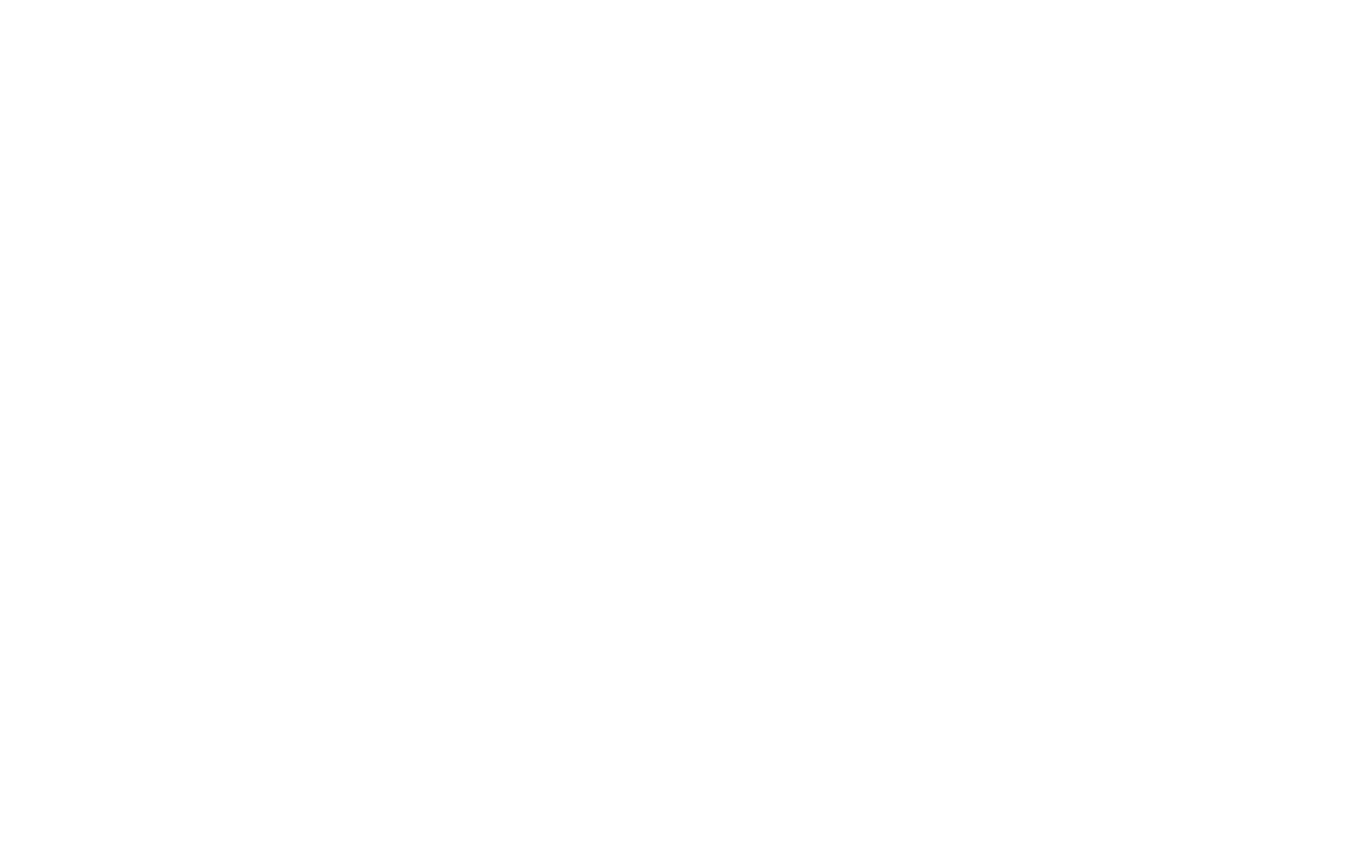

Two-Tower模型的关键在于不仅可以捕捉大量的user 本身feature，item本身的feature，还可以捕捉到非常多的user-item interaction的feature，并且通过user feature encoder，item feature encoder生成embedding，最后用dot product来衡量similarity或者是说user和item的关联性，而这种关联性就是推荐系统所需要的，最后产生推荐的时候只需要对特定的user产生出来关联性最大的几个item即可，这里往往还有一个reranking的环节，共同组成了Two-Tower模型。

User encoder和item encoder分别可以由Tree based model或者Deep Neural Network来代替，这一个部分的模型可以做的比较complex作为feature的extractor。而其后产生关联性的最后一个layer则往往用logistic regression来做，为的是最终上线模型的反复训练时候的速度考量。而reranking模型则一般可以更加复杂。

Two-Tower模型除了在推荐系统中广泛应用，在Search，QA等等系统中也得到了非常广泛的使用，这部分内容我们课程里会针对不同的系统给大家讲解Two-Tower模型是如何使用的。

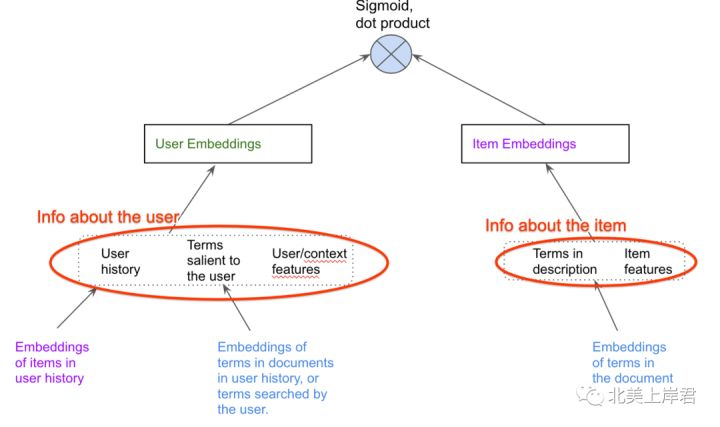

## The query tower - user model

Let's start with the query tower.

The first step is to decide on the dimensionality of the query and candidate representations:

- Higher values will correspond to models that may be more accurate, 
- but will also be slower to fit and more prone to overfitting.


In [13]:
embedding_dimension = 32

The second is to define the model itself. Here, we're going to use Keras preprocessing layers to first convert user ids to integers, and then convert those to user embeddings via an Embedding layer. Note that we use the list of unique user ids we computed earlier as a vocabulary:

In [32]:
# tf.keras.layers.StringLookup example
vocab = ["a", "b", "c", "d"]
data = tf.constant([["a", "c", "d"], ["d", "z", "b"]])
layer = tf.keras.layers.StringLookup(vocabulary=vocab)
layer(data)

<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
array([[1, 3, 4],
       [4, 0, 2]])>

In [14]:
user_model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.StringLookup(
      vocabulary=unique_user_ids, mask_token=None),
  # We add an additional embedding to account for unknown tokens.
  tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
])

A simple model like this corresponds exactly to a classic matrix factorization approach. While defining a subclass of tf.keras.Model for this simple model might be overkill, we can easily extend it to an arbitrarily complex model using standard Keras components, as long as we return an embedding_dimension-wide output at the end.

## the candidate tower- movie model

In [15]:
movie_model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.StringLookup(
      vocabulary=unique_movie_titles, mask_token=None),
  tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
])

## metrics

In our training data we have positive (user, movie) pairs. To figure out how good our model is, we need to compare the affinity score that the model calculates for this pair to the scores of all the other possible candidates: if the score for the positive pair is higher than for all other candidates, our model is highly accurate.

To do this, we can use the `tfrs.metrics.FactorizedTopK` metric. The metric has one required argument: the dataset of candidates that are used as implicit negatives for evaluation.

In our case, that's the `movies` dataset, converted into embeddings via our movie model:

In [16]:
metrics = tfrs.metrics.FactorizedTopK(
  candidates=movies.batch(128).map(movie_model)
)

## loss

The next component is the loss used to train our model. TFRS has several loss layers and tasks to make this easy.

In this instance, we'll make use of the `Retrieval` task object: a convenience wrapper that bundles together the loss function and metric computation:

In [21]:
task = tfrs.tasks.Retrieval(
  metrics=metrics
)

## full model

We can now put it all together into a model. TFRS exposes a base model class (`tfrs.models.Model`) which streamlines bulding models: all we need to do is to set up the components in the `__init__` method, and implement the `compute_loss` method, taking in the raw features and returning a loss value.

The base model will then take care of creating the appropriate training loop to fit our model.

In [19]:
class MovielensModel(tfrs.Model):

    def __init__(self, user_model, movie_model):
        super().__init__()
        self.movie_model: tf.keras.Model = movie_model
        self.user_model: tf.keras.Model = user_model
        self.task: tf.keras.layers.Layer = task

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False):
    # We pick out the user features and pass them into the user model.
        user_embeddings = self.user_model(features["user_id"])
    # And pick out the movie features and pass them into the movie model,
    # getting embeddings back.
        positive_movie_embeddings = self.movie_model(features["movie_title"])

    # The task computes the loss and the metrics.
        return self.task(user_embeddings, positive_movie_embeddings)

The `tfrs.Model` base class is a simply convenience class: it allows us to compute both training and test losses using the same method.

Under the hood, it's still a plain Keras model. You could achieve the same functionality by inheriting from `tf.keras.Model` and overriding the `train_step` and `test_step` functions (see [the guide](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit) for details):

In [17]:
class NoBaseClassMovielensModel(tf.keras.Model):

    def __init__(self, user_model, movie_model):
        super().__init__()
        self.movie_model: tf.keras.Model = movie_model
        self.user_model: tf.keras.Model = user_model
        self.task: tf.keras.layers.Layer = task

    def train_step(self, features: Dict[Text, tf.Tensor]):

    # Set up a gradient tape to record gradients.
        with tf.GradientTape() as tape:

      # Loss computation.
            user_embeddings = self.user_model(features["user_id"])
            positive_movie_embeddings = self.movie_model(features["movie_title"])
            loss = self.task(user_embeddings, positive_movie_embeddings)

      # Handle regularization losses as well.
            regularization_loss = sum(self.losses)

            total_loss = loss + regularization_loss

        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        metrics = {metric.name: metric.result() for metric in self.metrics}
        metrics["loss"] = loss
        metrics["regularization_loss"] = regularization_loss
        metrics["total_loss"] = total_loss

        return metrics

    def test_step(self, features: Dict[Text, tf.Tensor]):

    # Loss computation.
        user_embeddings = self.user_model(features["user_id"])
        positive_movie_embeddings = self.movie_model(features["movie_title"])
        loss = self.task(user_embeddings, positive_movie_embeddings)

    # Handle regularization losses as well.
        regularization_loss = sum(self.losses)

        total_loss = loss + regularization_loss

        metrics = {metric.name: metric.result() for metric in self.metrics}
        metrics["loss"] = loss
        metrics["regularization_loss"] = regularization_loss
        metrics["total_loss"] = total_loss

        return metrics

## fit

In [22]:
model = MovielensModel(user_model, movie_model)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [23]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

In [24]:
model.fit(cached_train, epochs=3)


Epoch 1/3
10/10 [==============================] - 7s 417ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0010 - factorized_top_k/top_5_categorical_accuracy: 0.0091 - factorized_top_k/top_10_categorical_accuracy: 0.0197 - factorized_top_k/top_50_categorical_accuracy: 0.0988 - factorized_top_k/top_100_categorical_accuracy: 0.1761 - loss: 69885.1143 - regularization_loss: 0.0000e+00 - total_loss: 69885.1143
Epoch 2/3
10/10 [==============================] - 4s 390ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0029 - factorized_top_k/top_5_categorical_accuracy: 0.0186 - factorized_top_k/top_10_categorical_accuracy: 0.0378 - factorized_top_k/top_50_categorical_accuracy: 0.1693 - factorized_top_k/top_100_categorical_accuracy: 0.2925 - loss: 67523.3672 - regularization_loss: 0.0000e+00 - total_loss: 67523.3672
Epoch 3/3
10/10 [==============================] - 4s 400ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0035 - factorized_top_k/top_5_categorical_accuracy: 

## predictions

Now that we have a model, we would like to be able to make predictions. We can use the tfrs.layers.factorized_top_k.BruteForce layer to do this.




In [25]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
# recommends movies out of the entire movies dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model)))
)

# Get recommendations.
_, titles = index(tf.constant(["42"]))
print(f"Recommendations for user 42: {titles[0, :3]}")

Recommendations for user 42: [b'Bridges of Madison County, The (1995)'
 b'Father of the Bride Part II (1995)' b'Rudy (1993)']


In [31]:
tfds.as_dataframe(ratings.take(2)).T

,0,1
movie_title,"b""One Flew Over the Cuckoo's Nest (1975)""",b'Strictly Ballroom (1992)'
user_id,b'138',b'92'


In [33]:
_, titles = index(tf.constant(["92"]))
print(f"Recommendations for user 92: {titles[0, :3]}")

Recommendations for user 92: [b'Just Cause (1995)' b'High School High (1996)' b'Mixed Nuts (1994)']


Of course, the BruteForce layer is going to be too slow to serve a model with many possible candidates. The following sections shows how to speed this up by using an approximate retrieval index.

## serving

After the model is trained, we need a way to deploy it.

In a two-tower retrieval model, serving has two components:

- a serving query model, taking in features of the query and transforming them into a query embedding, and
- a serving candidate model. This most often takes the form of an approximate nearest neighbours (ANN) index which allows fast approximate lookup of candidates in response to a query produced by the query model.



In TFRS, both components can be packaged into a single exportable model, giving us a model that takes the raw user id and returns the titles of top movies for that user. This is done via exporting the model to a SavedModel format, which makes it possible to serve using TensorFlow Serving.

To deploy a model like this, we simply export the BruteForce layer we created above:



In [ ]:
# Export the query model.
with tempfile.TemporaryDirectory() as tmp:
    path = os.path.join(tmp, "model")

  # Save the index.
    tf.saved_model.save(index, path)

  # Load it back; can also be done in TensorFlow Serving.
    loaded = tf.saved_model.load(path)

  # Pass a user id in, get top predicted movie titles back.
    scores, titles = loaded(["42"])

    print(f"Recommendations: {titles[0][:3]}")

We can also export an approximate retrieval index to speed up predictions. This will make it possible to efficiently surface recommendations from sets of tens of millions of candidates.

To do so, we can use the scann package. This is an optional dependency of TFRS, and we installed it separately at the beginning of this tutorial by calling !pip install -q scann.

Once installed we can use the TFRS ScaNN layer:




In [ ]:
scann_index = tfrs.layers.factorized_top_k.ScaNN(model.user_model)
scann_index.index_from_dataset(
  tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model)))
)

This layer will perform approximate lookups: this makes retrieval slightly less accurate, but orders of magnitude faster on large candidate sets.

In [ ]:
_, titles = scann_index(tf.constant(["42"]))
print(f"Recommendations for user 42: {titles[0, :3]}")

Exporting it for serving is as easy as exporting the BruteForce layer:



In [ ]:
with tempfile.TemporaryDirectory() as tmp:
  path = os.path.join(tmp, "model")

  # Save the index.
  tf.saved_model.save(
      index,
      path,
      options=tf.saved_model.SaveOptions(namespace_whitelist=["Scann"])
  )

  # Load it back; can also be done in TensorFlow Serving.
  loaded = tf.saved_model.load(path)

  # Pass a user id in, get top predicted movie titles back.
  scores, titles = loaded(["42"])

  print(f"Recommendations: {titles[0][:3]}")

To learn more about using and tuning fast approximate retrieval models, have a look at our efficient serving tutorial.

Item-to-item recommendation


In this model, we created a user-movie model. However, for some applications (for example, product detail pages) it's common to perform item-to-item (for example, movie-to-movie or product-to-product) recommendations.

Training models like this would follow the same pattern as shown in this tutorial, but with different training data. Here, we had a user and a movie tower, and used (user, movie) pairs to train them. In an item-to-item model, we would have two item towers (for the query and candidate item), and train the model using (query item, candidate item) pairs. These could be constructed from clicks on product detail pages.



this concludes the retrieval tutorial.

To expand on what is presented here, have a look at:

- Learning multi-task models: jointly optimizing for ratings and clicks.
- Using movie metadata: building a more complex movie model to alleviate cold-start.

# Sequential model

In our basic retrieval tutorial, we use one query tower for the user, and the candidate tow for the candidate movie. However, the two-tower architecture is generalizble and not limited to pair. You can also use it to do item-to-item recommendation as we note in the basic retrieval tutorial.

Here we are still going to use the two-tower architecture. Specificially, we use the query tower with a Gated Recurrent Unit (GRU) layer to encode the sequence of historical movies, and keep the same candidate tower for the candidate movie.

In [78]:
embedding_dimension = 32

query_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(
      vocabulary=unique_movie_ids, mask_token=None),
    tf.keras.layers.Embedding(len(unique_movie_ids) + 1, embedding_dimension), 
    tf.keras.layers.GRU(embedding_dimension),
])

candidate_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_movie_ids, mask_token=None),
  tf.keras.layers.Embedding(len(unique_movie_ids) + 1, embedding_dimension)
])

The metrics, task and full model are defined similar to the basic retrieval model.



In [79]:
metrics = tfrs.metrics.FactorizedTopK(
  candidates=movies.batch(128).map(candidate_model)
)

task = tfrs.tasks.Retrieval(
  metrics=metrics
)

In [80]:
class Model(tfrs.Model):

    def __init__(self, query_model, candidate_model):
        super().__init__()
        self._query_model = query_model
        self._candidate_model = candidate_model

        self._task = task

    def compute_loss(self, features, training=False):
        watch_history = features["context_movie_id"]
        watch_next_label = features["label_movie_id"]

        query_embedding = self._query_model(watch_history)       
        candidate_embedding = self._candidate_model(watch_next_label)

        return self._task(query_embedding, candidate_embedding, compute_metrics=not training)

In [81]:
model = Model(query_model, candidate_model)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [83]:
cached_train = train_ds.shuffle(10_000).batch(12800).cache()
cached_test = test_ds.batch(2560).cache()


In [84]:
model.fit(cached_train, epochs=3)


Epoch 1/3
67/67 [==============================] - 58s 838ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 108322.5045 - regularization_loss: 0.0000e+00 - total_loss: 108322.5045
Epoch 2/3
67/67 [==============================] - 43s 643ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 101044.1494 - regularization_loss: 0.0000e+00 - total_loss: 101044.1494
Epoch 3/3
67/67 [==============================] - 43s 639ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e

In [85]:
model.evaluate(cached_test, return_dict=True)


37/37 [==============================] - 9s 219ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0148 - factorized_top_k/top_5_categorical_accuracy: 0.0797 - factorized_top_k/top_10_categorical_accuracy: 0.1374 - factorized_top_k/top_50_categorical_accuracy: 0.3753 - factorized_top_k/top_100_categorical_accuracy: 0.5073 - loss: 15493.6830 - regularization_loss: 0.0000e+00 - total_loss: 15493.6830


{'factorized_top_k/top_1_categorical_accuracy': 0.014786938205361366,
 'factorized_top_k/top_5_categorical_accuracy': 0.07971300184726715,
 'factorized_top_k/top_10_categorical_accuracy': 0.13743217289447784,
 'factorized_top_k/top_50_categorical_accuracy': 0.3752705156803131,
 'factorized_top_k/top_100_categorical_accuracy': 0.5072655081748962,
 'loss': 9400.3447265625,
 'regularization_loss': 0,
 'total_loss': 9400.3447265625}